[*********************100%***********************]  1 of 1 completed


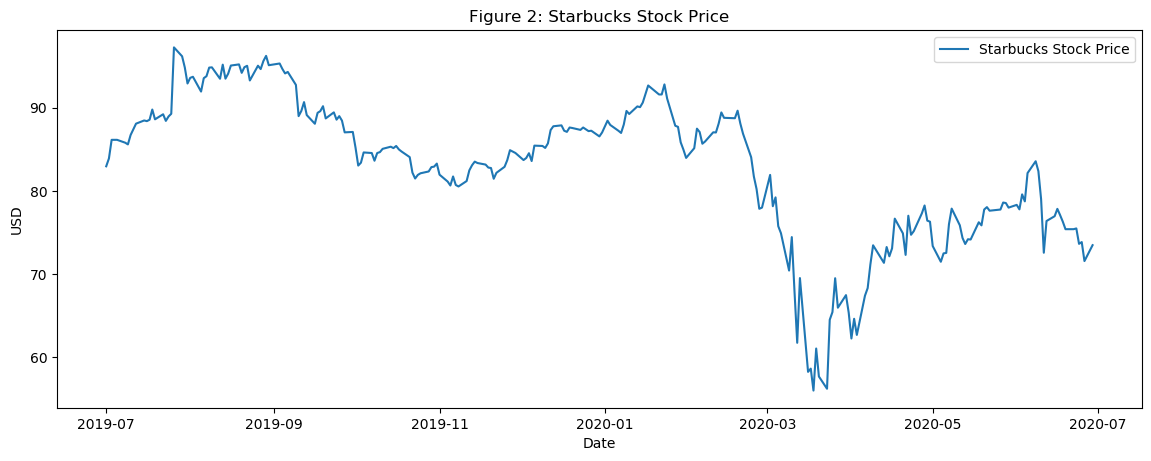

In [1]:

from utils import *
import time
import numpy as np
import pandas as pd
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)


def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')


import yfinance as yf

# Get the data for the stock AAPL
start = '2019-06-30'
end = '2020-06-30'

data = yf.download('SBUX', start, end)


data = data.reset_index()
data

data.dtypes


# re-name field from 'Adj Close' to 'Adj_Close'
data = data.rename(columns={"Adj Close": "Adj_Close"})
data


data = data.loc[:,['Date','Adj_Close']]
       

# Plot all the close prices
# ((data.pct_change()+1).cumprod()).plot(figsize=(10, 7))


plt.figure(figsize=(14, 5), dpi=100)
plt.plot(data['Date'], data['Adj_Close'], label='Starbucks Stock Price')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Starbucks Stock Price')
plt.legend()
plt.show()


In [3]:

num_training_days = int(data.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, data.shape[0]-num_training_days))


# TECHNICAL INDICATORS
#def get_technical_indicators(dataset):
# Create 7 and 21 days Moving Average
data['ma7'] = data['Adj_Close'].rolling(window=7).mean()
data['ma21'] = data['Adj_Close'].rolling(window=21).mean()


# Create exponential weighted moving average
data['26ema'] = data['Adj_Close'].ewm(span=26).mean()
data['12ema'] = data['Adj_Close'].ewm(span=12).mean()
data['MACD'] = (data['12ema']-data['26ema'])

# Create Bollinger Bands
data['20sd'] = data['Adj_Close'].rolling(window=20).std() 
data['upper_band'] = data['ma21'] + (data['20sd']*2)
data['lower_band'] = data['ma21'] - (data['20sd']*2)

# Create Exponential moving average
data['ema'] = data['Adj_Close'].ewm(com=0.5).mean()

# Create Momentum
data['momentum'] = data['Adj_Close']-1
    

dataset_TI_df = data
dataset = data



Number of training days: 176. Number of test days: 76.


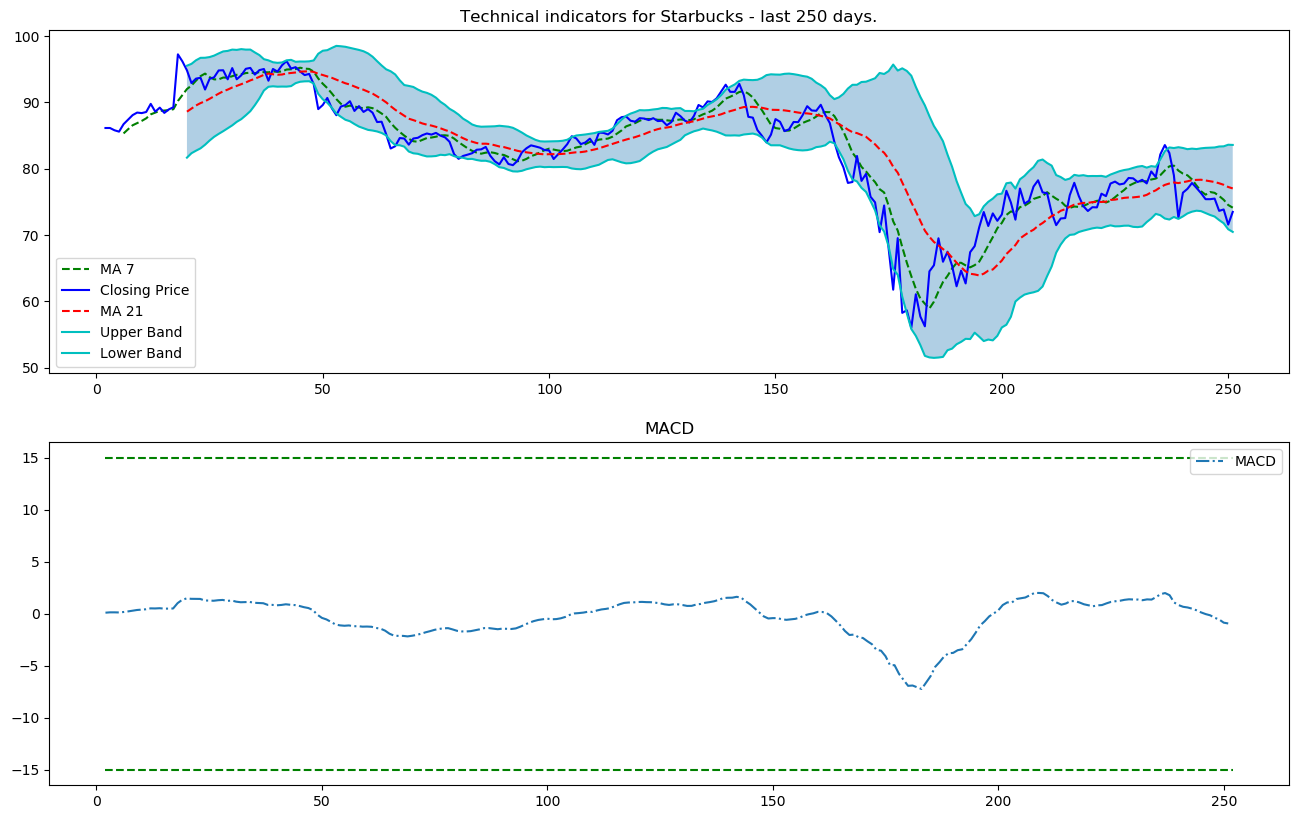

In [7]:

def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Adj_Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Starbucks - last {} days.'.format(last_days))
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    # plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

plot_technical_indicators(dataset_TI_df, 250)


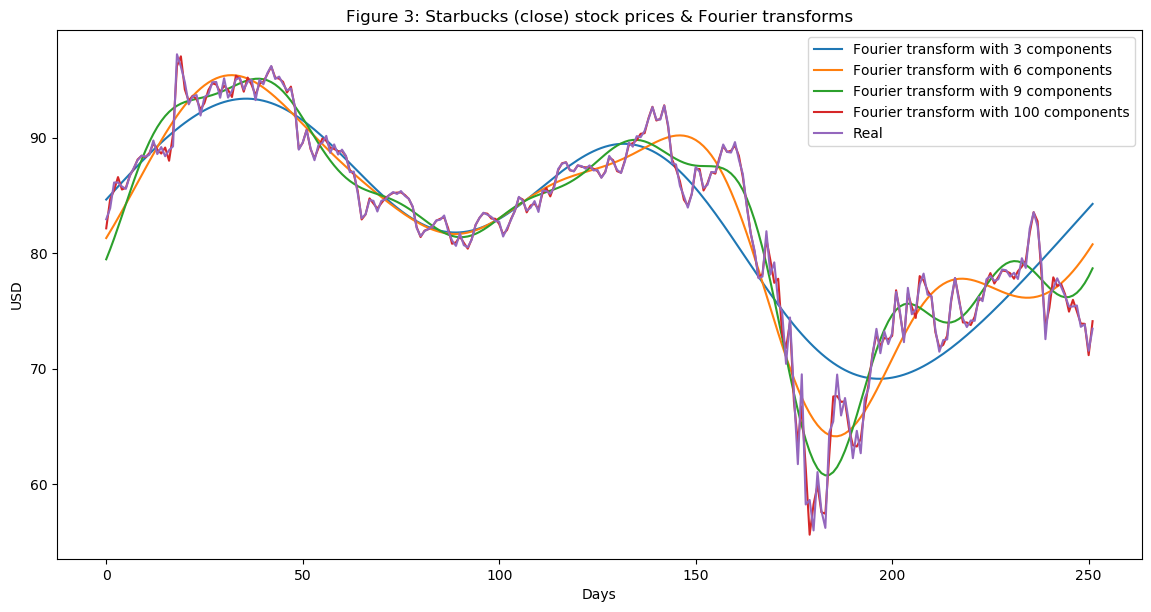

In [8]:

# Fourier transforms for trend analysis
# just import bert
import bert


data_FT = dataset_TI_df[['Date', 'Adj_Close']]

close_fft = np.fft.fft(np.asarray(data_FT['Adj_Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Adj_Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Starbucks (close) stock prices & Fourier transforms')
plt.legend()
plt.show()


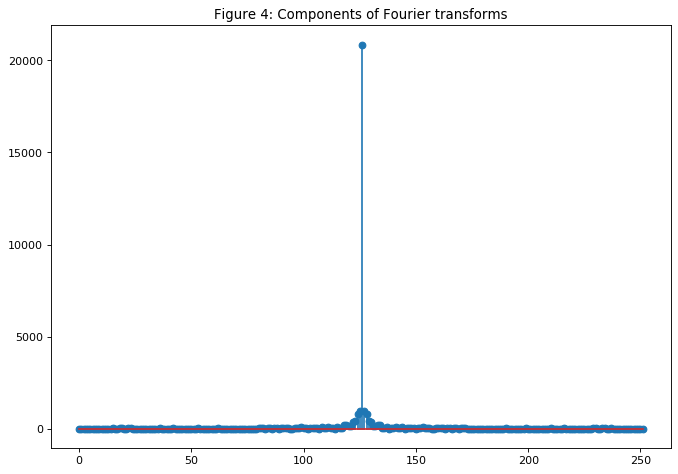

In [9]:

from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()


In [10]:

# ARIMA as a feature
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['Adj_Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())


                             ARIMA Model Results                              
Dep. Variable:            D.Adj_Close   No. Observations:                  251
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -525.697
Method:                       css-mle   S.D. of innovations              1.965
Date:                Thu, 23 Jul 2020   AIC                           1065.393
Time:                        16:59:34   BIC                           1090.072
Sample:                             1   HQIC                          1075.325
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0389      0.111     -0.350      0.726      -0.256       0.179
ar.L1.D.Adj_Close    -0.2069      0.063     -3.278      0.001      -0.331      -0.083
ar.L2.D.Adj_Close     0.

In [11]:

from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)


Test MSE: 10.138


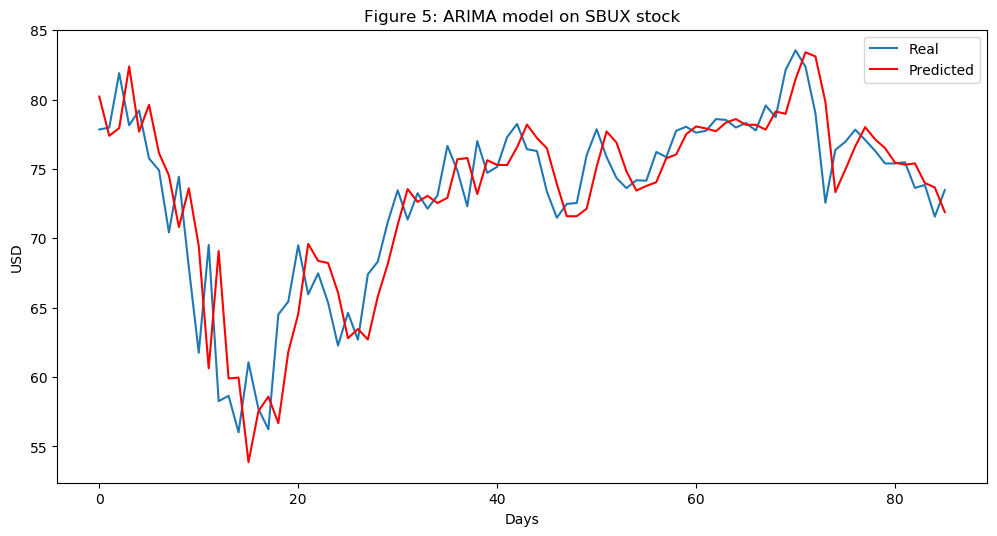

In [12]:

# Plot the predicted (from ARIMA) and real prices
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on SBUX stock')
plt.legend()
plt.show()
